In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   

# Prepare FD and LBM solution

In [12]:
u_ic = np.zeros(200)
u_ic[75:-75] = 1
np.savetxt("initial.csv", u_ic, delimiter=",")

CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', 200)
CLBc.addGeomParam('ny', 100)


CLBc.addRunR(eval=\
"""
    init = read.table("initial.csv", header = FALSE, sep = "", dec = ".");
    Solver$Fields$Init_DRE_1_External[] = init[,1];
    Solver$Actions$InitFromExternalAction();
""")

    
params = {
        "Diffusivity_DRE_1":0.1666,
        "Init_DRE_1":-0.5
}

CLBc.addModelParams(params)


CLBc.addHDF5()
solve = CLBc.addSolve(iterations=200)
CLBc.addHDF5(Iterations=10, parent=solve)
   
CLBc.write('run.xml')

! tclb d2q9_reaction_diffusion_system_SimpleDiffusion run.xml > /dev/null && echo 'DONE!'


Hello allocator!
DONE!


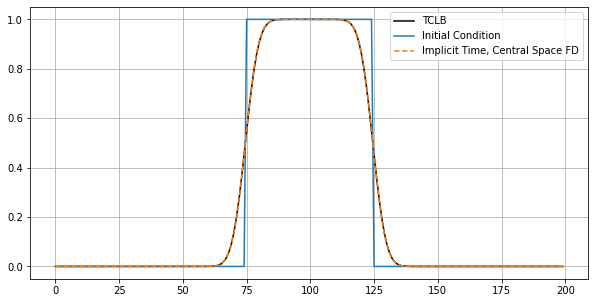

In [13]:
def btcs(u_IC, nu, nx, nt, dt, dx):
    
    un_icfd = u_IC.copy()
    A = np.zeros((nx, nx))
    
    
    
    Beta_FD = dt * nu / (dx**2) 
    # nt += 100
    last_index_in_matrix = nx -1 
    # the BC  - use one sided FD            
    A[0, 0] = 1-Beta_FD     # forward FD
    A[0, 1] = 2*Beta_FD     # forward FD 
    A[0, 2] = -Beta_FD      # forward FD 
    A[last_index_in_matrix, last_index_in_matrix-2] = -Beta_FD   # backward FD 
    A[last_index_in_matrix, last_index_in_matrix-1] = 2*Beta_FD  # backward FD 
    A[last_index_in_matrix, last_index_in_matrix] =  1-Beta_FD   # backward FD 
    for i in range(1, last_index_in_matrix): 
        A[i, i-1] = -Beta_FD        # left of the diagonal
        A[i, i] = 1 + 2*Beta_FD     # the diagonal
        A[i, i+1] = -Beta_FD         # right of the diagonal   

    A_inv = np.linalg.inv(A)
    solution = list()
    solution.append(u_ic)
    for n in range(nt):  #loop for values of n from 0 to nt, so it will run nt times
        un_icfd = A_inv@un_icfd
        solution.append(un_icfd)
    
    return np.array(solution)
        
    
u_ic = np.loadtxt("initial.csv", delimiter=",")    
    
SolutionFD = btcs(u_ic, 0.1666, u_ic.shape[0], 200, 1, 1)



SolutioLBM = list()

for i in range(0,200,10):
    f = h5py.File('./output/run_HDF5_%08d.h5'%i)    
    SolutioLBM.append(f['DRE_1'][0,:,:])
    
SolutioLBM = np.array(SolutioLBM)

plt.figure(figsize=(10,5))
plt.plot(SolutioLBM[5,25,:].T, 'k-', label='TCLB');
plt.plot(SolutionFD[0,:], label='Initial Condition')
plt.plot(SolutionFD[50,:], '--', label='Implicit Time, Central Space FD')
plt.legend()
plt.grid(which='both')

# Get FFT of both

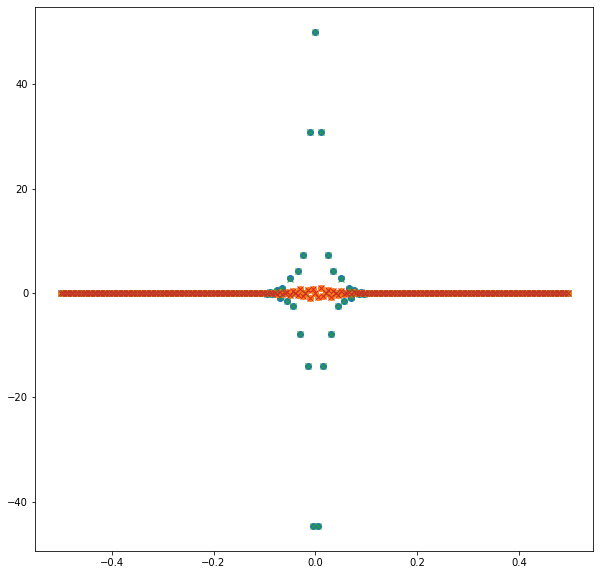

In [15]:
plt.figure(figsize=(10,10))
s = u_ic
s_ic = np.fft.fft(s)
freq = np.fft.fftfreq(s.shape[-1])
#plt.plot(freq, s_ic.real, '--', freq, s_ic.imag, '--')


s = SolutionFD[50,:]
s_fd = np.fft.fft(s)
#freq = np.fft.fftfreq(s.shape[-1])
plt.plot(freq, s_fd.real, 'o', freq, s_fd.imag, 'o')

s = SolutioLBM[5,25,:].T
s_lbm = np.fft.fft(s)
#freq = np.fft.fftfreq(s.shape[-1])
plt.plot(freq, s_lbm.real, 'x', freq, s_lbm.imag, 'x')


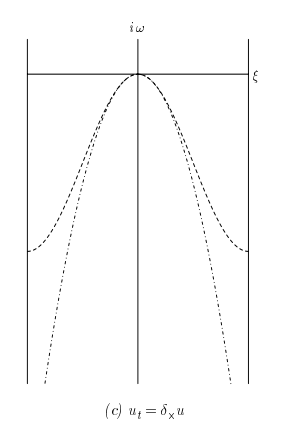

#Ref: https://people.maths.ox.ac.uk/trefethen/5all.pdf

/tmp/ipykernel_6618/4255232911.py:2: RuntimeWarning: divide by zero encountered in true_divide
  omega =  s_fd / s_ic
/tmp/ipykernel_6618/4255232911.py:2: RuntimeWarning: invalid value encountered in true_divide
  omega =  s_fd / s_ic
/tmp/ipykernel_6618/4255232911.py:6: RuntimeWarning: divide by zero encountered in true_divide
  omega = s_lbm / s_ic
/tmp/ipykernel_6618/4255232911.py:6: RuntimeWarning: invalid value encountered in true_divide
  omega = s_lbm / s_ic
/tmp/ipykernel_6618/4255232911.py:11: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogy(af, np.tanh(scale*af)/af/scale, '--', label='~Dispersion relation for laplace')


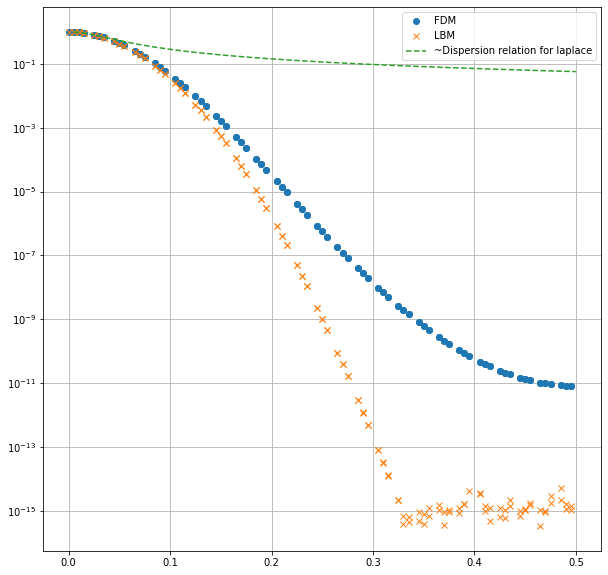

In [106]:
plt.figure(figsize=(10,10))
omega =  s_fd / s_ic
plt.plot(np.abs(freq), np.abs(omega), 'o', label='FDM')


omega = s_lbm / s_ic
plt.plot(np.abs(freq), np.abs(omega), 'x', label='LBM')

af = np.sort(np.abs(freq))
scale = 35
plt.semilogy(af, np.tanh(scale*af)/af/scale, '--', label='~Dispersion relation for laplace')

plt.legend()
plt.grid(which='both')